# An analysis of the dataset presented in [this technical comment](https://arxiv.org/abs/2004.06601), but *without* our quality cuts applied

In the previous notebook, `BMRS20_mos_our_cuts.ipynb`, we analyzed the subset of the the [BRMS](https://arxiv.org/abs/2004.06601) dataset that passed our quality cuts as defined in [Dessert et al. _Science_ 2020](https://science.sciencemag.org/content/367/6485/1465) (DRS20). We found no evidence for the 3.5 keV line and ruled out the relevant region of parameter space even with our conservative analysis.

In this notebook, we repeat this analysis on the entire 17 Ms BRMS dataset: all of the data, not just the subset that passes the quality cuts. 

If you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

**Please direct any questions to bsafdi@umich.edu.**

In [1]:
# Import required modules

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np

from scipy.stats import chi2 as chi2_scipy
from scipy.optimize import dual_annealing
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

**NB**: In this notebook, we minimize with `scipy` so that it is easy to run for the interested reader. For scientific analysis, we recommend [Minuit](https://iminuit.readthedocs.io/en/latest/) as a minimizer. In our paper, we used Minuit.

# Define signal line energy

By default we will look for an anomalous line at 3.48 keV, as defined by the EUXL parameter below, denoting the energy of the unidentified X-ray line. Lines at different energies can be searched for by changing this parameter accordingly (for example to 3.55 keV as in the first notebook). We start with 3.48 keV as this is the fiducial line energy in BMRS.

In [2]:
EUXL = 3.48 # [keV]

**NB:** changing EUXL will of course vary the results below, and values in the surrounding discussion will not necessarily be reflective.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties. 

We will use data from two regions of interest (ROI):
- **Signal Region (SR)**: 20-35 degrees from the Galactic Center, this was the fiducial ROI in BRMS (DRS20 instead used 5-45);
- **Background Region (BR)**: 60-90 degrees from the Galactic Center, a useful region for studying background as it contains less dark matter.

We also load the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

In [3]:
## Signal Region (20-35 degrees)
data = np.load("../data/data_mos_boyarsky_ROI_their_cuts.npy") # [cts/s/keV]
data_yerrs = np.load("../data/data_yerrs_mos_boyarsky_ROI_their_cuts.npy") # [cts/s/keV]
QPB = np.load("../data/QPB_mos_boyarsky_ROI_their_cuts.npy") # [cts/s/keV]

# Exposure time
Exp = 16.55e6 # [s]

# D-factor averaged over the signal ROI
D_signal = 4.46e28 # [keV/cm^2]


## Background Region (60-90 degrees)

# Data and associated errors
data_bkg = np.load("../data/data_mos_bkg_ROI.npy") # [cts/s/keV]
data_yerrs_bkg = np.load("../data/data_yerrs_mos_bkg_ROI.npy") # [cts/s/keV]

# Exposure time
Exp_bkg = 67.64e6 # [s]

# D-factor averaged over the background ROI
D_bkg = 1.91e28 # [keV/cm^2]

## Energy binning appropriate for both the signal and background
Energies=np.load("../data/mos_energies.npy") # [keV]

## Load in the Models

Next we use the models that will be used in fitting the above data.

There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_UXL` gives the detectors counts as a function of energy after forward modeling a physical line at EUXL keV with a flux of 1 cts/cm$^2$/s/sr.

In [4]:
# Load the forward-modeled lines and energies
mods = np.load("../data/mos_mods.npy")
Es_line = np.load("../data/mos_mods_line_energies.npy")

# Load the detector response
det_res = np.load("../data/mos_det_res.npy")

arg_UXL = np.argmin((Es_line-EUXL)**2)
mod_UXL = mods[arg_UXL]

print "The energy of our "+str(EUXL)+" keV line example will be: "+str(Es_line[arg_UXL])+" keV"

# How to go from flux to sin^2(2\theta)
def return_sin_theta_lim(E_line,flux,D_factor):
    """
    D_factor [keV/cm^2]
    flux [cts/cm^2/s/sr]
    E_line [keV] (dark matter mass is twice this value)
    returns: associated sin^2(2theta)
    """
    DMmass = 2.*E_line
    res = (4.*np.pi*DMmass/D_factor)/1.361e-22*(1/DMmass)**5*flux
    return res

The energy of our 3.48 keV line example will be: 3.4824707846410687 keV


# Visualize the data

Data in the signal region, where the dashed vertical line denotes the location of a putative signal line. Note that the BMRS dataset has a flux 50% larger than when restricted to the set that passes our quality cuts, highlighting the importance of implementing these cuts. In addition, this extra extended emission (above the irreducible detector and cosmic backgrounds) may have complicated energy-dependence that cannot be described by a simple background model such as a power law. Finally, these backgrounds are stacked, further increasing the likelihood that the background may systematically deviate from a simple model.

/sw/lsa/centos7/python-anaconda2/2019.03/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


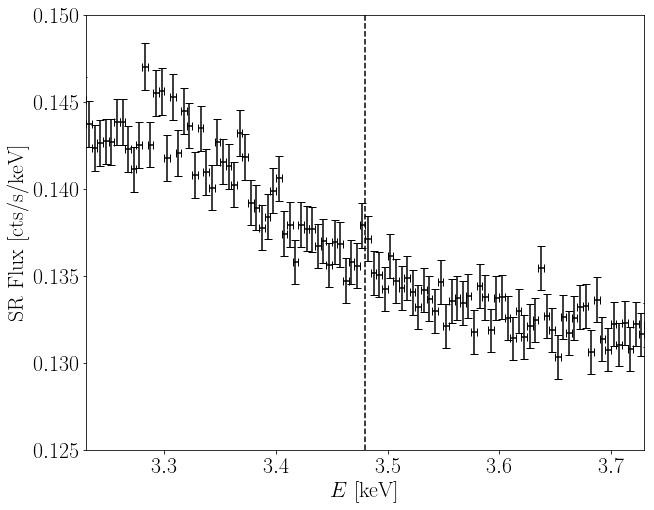

In [5]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.125,0.15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.show()

# Statistical analysis

Now, let's perform a rigorous statistical analysis, using profile likelihood. As we operate in the large counts limit for the stacked data, we can perform a simple $\chi^2$ analysis rather than a full joint likelihood analysis as used by default in Dessert et al. 2020.

In [6]:
## Define the functions we will use

class chi2:
    """ A set offunctions for calculation the chisq associated with different hypotheses
    """
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig

## Fit within $E_{\rm UXL} \pm 0.25$ keV

First, we will fit the models from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV. Later in this notebook, we broaden this range to 3.0 to 4.0 keV. For the default $E_{\rm UXL} = 3.48$ keV, this corresponds to $3.23~{\rm keV} < E < 3.73~{\rm keV}$.

To begin with then, let's reduce the dataset to this restricted range.

In [7]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

Next, let's fit this data with the background only hypothesis and consider the quality of fit.

## The background model

Here we model the continuum background as a quadratic. In addition, we add degrees of freedom associated with the possible background lines at 3.3 keV and 3.7 keV. 

In [8]:
arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

def mod_poly_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, B, C, S1, S2 = x

    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.50053349, -0.18701816,  0.02353692,  0.06814053,
        0.01880195]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3],mn_null_line.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

The Delta chi^2 between signal and null model is: 1.0568783470870926
The chi^2/DOF of the null-model fit is: 0.8595653580677374
Expected 68% containment for the chi^2/DOF: [0.85614219 1.14370943]
Expected 95% containment for the chi^2/DOF: [0.73605123 1.30376807]


The inclusion of additional lines has not changed our conclusion. The null model is still a good fit to the data, although we find a very mild preference for nonzero signal $\Delta \chi^2 \sim 1$.

Here we plot the best fit signal and background model.

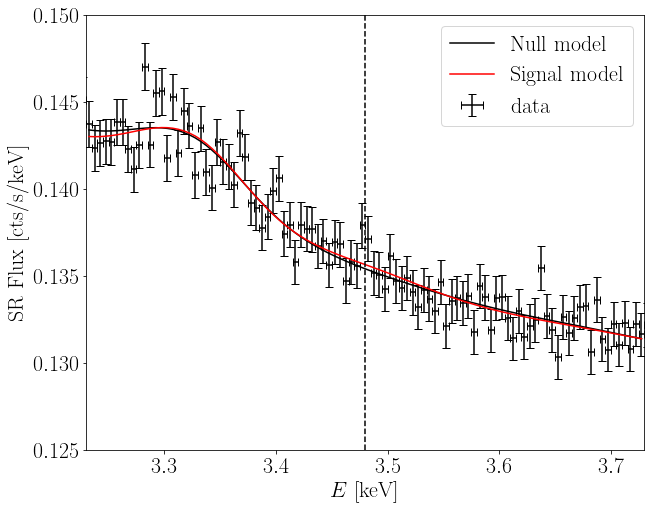

In [9]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.125,0.15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the associated limit via profile likelihood.

In [10]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.03494126304163253 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 3.082609562443865e-11


Recall that this same analysis on the clean dataset in the previous notebook found a limit of $\sin^2(2\theta) = 2.38 \times 10^{-11}$, but despite the increased exposure time the limit here is worse, partially due to the increased background rate. Nevertheless even this limit is fairly safely excluding the 3.5 keV line.

## Powerlaw background model

Now let's try a power law for the continuum background model (along with the two lines) as done in BMRS. Given that the stacked data is the sum of power laws, we would not expect the stacked data to be a power law itself, although we find it to be a reasonable description.  

In [11]:
def mod_power_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, n, S1, S2 = x

    return A*ens**n +  S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.30859773, -0.66268936,  0.06355456,  0.03587628]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-4.)

The Delta chi^2 between signal and null model is: 0.5945993912376792
The chi^2/DOF of the null-model fit is: 0.8541692074168763


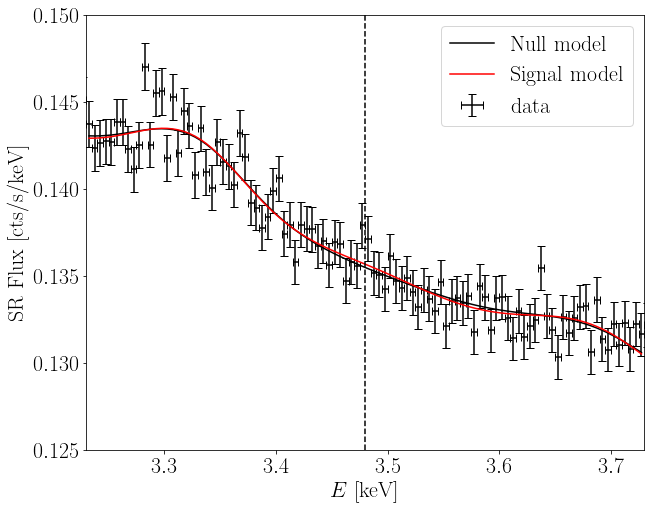

In [12]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.125,0.15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [13]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.027480758948516815 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.4244243894955322e-11


The power law continuum background does not substantively change the results, although any mild preference for a line has decreased to $\Delta \chi^2 \sim 0.6$. For reference, on the clean dataset, we found $\sin^2(2\theta) = 1.82 \times 10^{-11}$. Note this is the same procedure as in BMRS's test color-coded red in their Fig. 1 and Tab. 1, and performed on the same dataset. In that analysis, they find marginal 1.3$\sigma$ evidence for a line, although here we are unable to reproduce the result with the same significance.

# Departing from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV

We now fit the same dataset over the 3-4 keV range. Note that going to a wider energy range can open the analysis up to a variety of systematic issues associated with deviations from the background model around the energy of interest. This is exactly why in our fiducial analysis we stuck to the narrow energy range. In this case, the inclusion of data with high backgrounds can exacerbate these issues.

Our procedure is as follows. Firstly, we update the dataset. Then we will define a new background model incorporating these additional lines. Finally we repeat our default $\chi^2$ fit procedure. Note that we continue to use a power law continuum background model here. As such, the following analysis is a reproduction of the BMRS magenta color-coded analysis. In that magenta analysis, they claim a 4.0$\sigma$ detection of a line at 3.48 keV. Let us see what we obtain.

In [14]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) 
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]


def mod_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return A*ens**n + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_four_lines,mod_UXL_reduced)


x0 = np.array([0.33315606 ,-0.72351094,  0.0494905 ,  0.04189487,  0.14450233,
  0.06215284])
bounds = np.array([[1e-6,5],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

boundss = np.array([[-0.5,0.5],[1e-6,5],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.33325016 -0.72372844  0.0503624   0.04251432  0.14438536  0.06221247]
Best fit signal+background parameters: [ 0.00886512  0.33312208 -0.72409931  0.05170324  0.04417607  0.14438536
  0.06497322]
The Delta chi^2 between signal and null model is: 2.6285143425577644
The chi^2/DOF of the null-model fit is: 0.9174177924724561
NB: the best-fit signal strength in this case is: 0.008865118945648565 cts/cm$^2$/s/sr


Now we find modest evidence for the line with $\Delta \chi^2 \sim 2.6$, corresponding to $\sim 1.6 \sigma$. Note that on our cleaner dataset we found no evidence for the line, and in the analysis in the narrower energy range we also found no evidence. Note that the best-fit signal strength is much smaller than would be expected for the 3.5 keV line. There is no reason to expect that the background models employed here are reasonable physical descriptions of the data at the level of the signal, given the lack of quality cuts and stacking procedure. In fact, if one compares the plots of the data over the 3-4 keV range between the datasets with and without the quality cuts, the additional lines are prominent in the data without the quality cuts. This highlights that the full BMRS dataset includes significant reducible background that could easily systematically differ from the models used in this notebook and in BMRS.

Let's have a look at the best fit signal and background models in this case. There are subtle difference between the two, but no clear excess is appearing at 3.48 keV. We also look at the downward fluctuation interpretation of the Chandra blank sky detection, as in previous notebooks.

In [15]:
flux_ill = 4.8e-11 / return_sin_theta_lim(EUXL,1.,D_signal)
print "Flux [cts/cm^2/s/sr] and sin^(2\theta) for illustration: ", flux_ill, return_sin_theta_lim(EUXL,flux_ill,D_signal)

chi2_instance.fix_signal_strength(flux_ill)

mn_f = dual_annealing(chi2_instance.chi2_fixed_signal,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)
print "Delta chi^2 between fixed signal and null:", mn_null.fun-mn_f.fun

Flux [cts/cm^2/s/sr] and sin^(2	heta) for illustration:  0.0544078188309 4.8e-11
Delta chi^2 between fixed signal and null: -25.166893035737758


Let's have a look at the best fit signal and background models in this case. There are subtle difference between the two, but no clear excess is appearing at 3.55 keV. Again, we emphasize that while we are averaging the data in the plot, we didn't in the analysis.

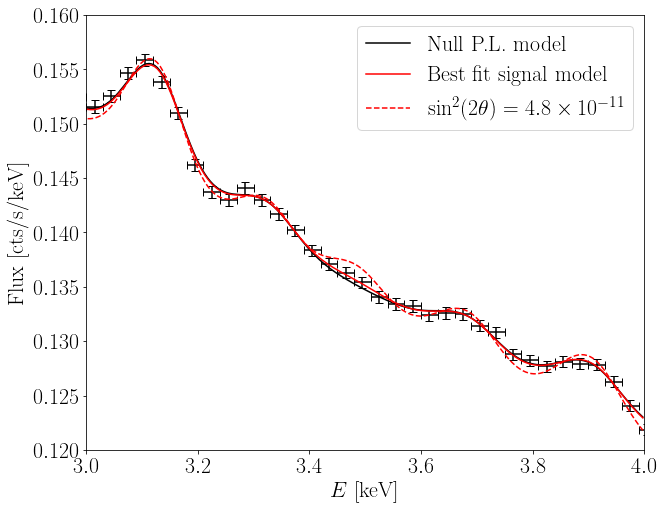

In [16]:
def avg_data(data,n):
    return np.mean(data.reshape(-1, n), axis=1)

fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_f.x)+chi2_instance._A_sig*mod_UXL_reduced,
         'r--',label =r"$\sin^2(2\theta) = 4.8 \times 10^{-11}$")

plt.xlim(3,4)
plt.ylim(0.12,0.16)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally, we compute the limit in this case using the by now familiar procedure.

In [17]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.0279782960012058 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.46831840885201e-11


Although this analysis found mild evidence for a feature at 3.48 keV, the signal strength is incompatible with previous detections. The limits from the analysis strongly rule out the 3.5 keV line. Note that in when run on the clean data the limit we obtain with this procedure is $\sin^2(2\theta) = 1.34 \times 10^{-11}$.

## Now with a polynomial background

Here we repeat the earlier analysis but with a polynomial background model, as used in the stacked analysis in DRS20 Supplementary Material Sec. 2.9.

In [18]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) #3.12 #should really be 3.128
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

def mod_poly_four_lines(ens,x):
    A, B, C,S1, S2, S3, S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_UXL_reduced)


x0 = np.array([ 0.30869963, -0.0713862,   0.00615966,  0.05397736,  0.05030442,
  0.15154157 , 0.07303334 ])
bounds = np.array([[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.4],[0,0.4],[0,0.4],[0,0.4]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

boundss = np.array([[-0.5,0.5],[-1,1],[-0.5,0.5],[-0.1,0.1],[0,0.4],[0,0.4],[0,0.4],[0,0.4]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=3000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-7.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.30914556 -0.07144193  0.00616596  0.0483137   0.04350965  0.14455668
  0.0655194 ]
Best fit signal+background parameters: [ 0.01215232  0.3085833  -0.07133463  0.00615449  0.05402906  0.05020379
  0.15167968  0.07291616]
The Delta chi^2 between signal and null model is: 2.770358494073321
The chi^2/DOF of the null-model fit is: 0.9262366452275208
NB: the best-fit signal strength in this case is: 0.012152315685778207 cts/cm$^2$/s/sr


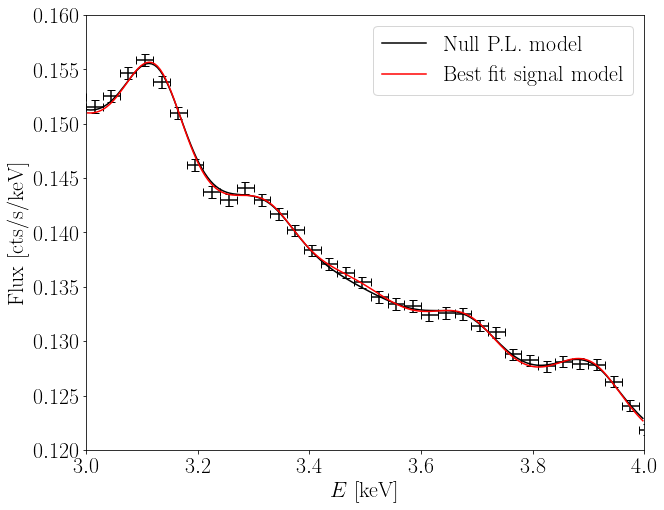

In [19]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.12,0.16)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [20]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.037384105228592736 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 3.2981234857983934e-11


This change to the background continuum model does not change any conclusions. The 3.5 keV line is ruled out by these limits.  Note that when we analyze the clean data the limit we obtain with this procedure is $\sin^2(2\theta) = 2.45 \times 10^{-11}$.

## Subtract background

Now, we subract off the data taken far away from the Galactic Center.  We use a folded powerlaw under the assumption that the residual flux in the signal region should be astrophysical.

In [21]:
def folded_PL(A,n):
    mod_F = np.matmul(det_res,A*Energies**n) 
    return mod_F

def mod_folded_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced- data_bkg[whs_reduced],np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_folded_power_four_lines,mod_UXL_reduced)

x0 = np.array([0.20973079, -0.93929346, 0.0378921, 0.02026992, 0.11586201, 0.04131473])
bounds = np.array([[0.0,0.5],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

boundss = np.array([[-0.5,0.5],[0.0,0.5],[-2,0],[0,0.1],[0,0.2],[0,0.2],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr or \n\
sin^2(2theta) =",return_sin_theta_lim(EUXL,mn.x[0],D_signal-D_bkg)

Best fit background parameters: [ 0.20973079 -0.93929346  0.0378921   0.02026992  0.11586201  0.04131473]
Best fit signal+background parameters: [ 0.01852694  0.2131194  -0.95932817  0.04587247  0.03162561  0.12474057
  0.05455508]
The Delta chi^2 between signal and null model is: 5.5612072645835156
The chi^2/DOF of the null-model fit is: 0.8530485942394116
NB: the best-fit signal strength in this case is: 0.01852693613477678 cts/cm$^2$/s/sr or 
sin^2(2theta) = 2.858763341234833e-11


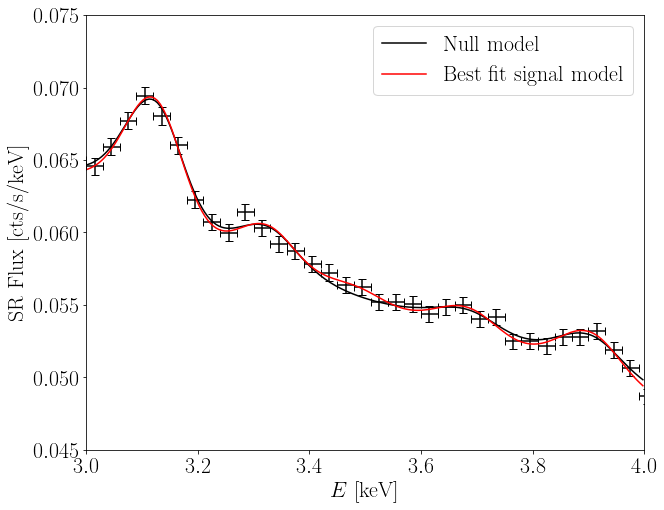

In [22]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data-data_bkg,6),yerr=np.sqrt(6*avg_data(data_yerrs**2+data_yerrs_bkg**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"


plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.045,0.075)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Note that the null model is generally underpredicting the data between 3.4 and 3.6 keV, and correspondingly a line at 3.45 is mildly preferred with TS ~ 5.6.

In [23]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal-D_bkg)

The 95% upper limit on the signal flux is 0.03156123531128337 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 4.8699958727995207e-11


Despite the mild evidence for a feature (ignoring the possibility for the moment that it is likely due to background mismodeling), the analysis still place strong tension on the conventional 3.5 keV line parameters, indicating that even if this feature was real it is not naively consistent with the original detection. That said, the background mismodeling in the vicinity of the line points to a more likely explanation as a local systematic deviation from the simplistic background models employed here. Note that when analyzing only the dataset passing our quality cuts, we see no such feature nor background mismodeling, and we obtain a much stronger limit of $\sin^2(2\theta) = 2.48 \times 10^{-11}$, in mild tension with the best-fit point here of $\sin^2(2\theta) = 2.86 \times 10^{-11}$.

# Include the Quiescent Particle Background (QPB)

Now we will do a joint likelihood including the QPB data.  The QPB data is complicated because the data is correlated from observation to observation.  Thus, summing the data leads to correlated uncertainties.  Thus, we will estimate the uncertainties on the QPB data in a data-driven way by fixing the normalization of the $\chi^2$ function such that the powerlaw gives the expected $\chi^2/{\rm DOF}$.  We note that this is just an approximation, which is not necessary within the context of the full joint likelihood framework.

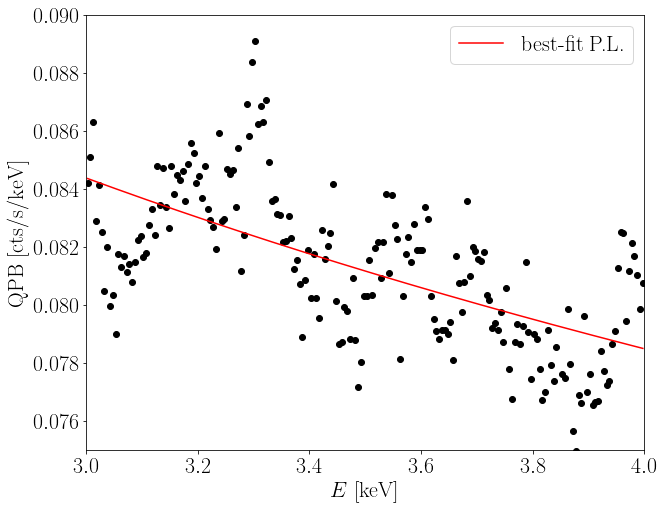

In [24]:
# We are going to fix a powerlaw to the QPB data and then renormalize the chi^2 function
def PL(A,n,ens):
    return A*ens**n

def chi2_QPB_UN(x):
    A,n = x
    mod = PL(A,n,Energies_reduced)
    return np.sum((mod-QPB[whs_reduced])**2)

mn_QPB = minimize(chi2_QPB_UN,[0.084,-0.20],method="Nelder-Mead")
bf_QPB=mn_QPB.x

chi2_not_reduced = chi2_QPB_UN(bf_QPB)

# The function below has the expected normalization
chi2_QPB = lambda x: chi2_QPB_UN(x)/chi2_not_reduced*((len(QPB[whs_reduced])-2.))

fig = plt.figure(figsize=(10,8))
plt.scatter(Energies_reduced,QPB[whs_reduced],marker="o",color="black")
plt.plot(Energies_reduced,PL(bf_QPB[0],bf_QPB[1],Energies_reduced),'r-',label="best-fit P.L.")
plt.xlim(3,4)
plt.ylim(0.075,0.09)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"QPB [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [25]:
def mod_2power_four_lines(ens,x):
    AQPB, nQPB,A, n,S1, S2, S3, S4 = x
    return PL(AQPB,nQPB,ens)+ folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_2power_four_lines,mod_UXL_reduced)


x0 = np.array([0.11129247, -0.25195735 , 0.40423702 ,-1.50156748  ,0.06552511,
  0.04919298 , 0.14941789  ,0.06836176])
bounds = np.array([[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])

# Below is the joint likelihood for the null model
def joint_chi2(x):
    return chi2_QPB(x[:2])+chi2_instance.chi2_null(x)

mn_null = dual_annealing(joint_chi2,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

# Below is the joint likelihood for the signal model
def joint_chi2_sig(x):
    return chi2_QPB(x[1:3])+chi2_instance.chi2(x)
boundss = np.array([[-0.5,0.5],[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6],mn_null.x[7]])
mn = dual_annealing(joint_chi2_sig,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr or \n\
sin^2(2theta) =",return_sin_theta_lim(EUXL,mn.x[0],D_signal-D_bkg)

Best fit background parameters: [ 0.11176284 -0.25533859  0.38857047 -1.46020563  0.05538022  0.0343882
  0.1385736   0.05110511]
Best fit signal+background parameters: [ 0.0235826   0.11128904 -0.25191886  0.40424875 -1.50151702  0.06544413
  0.04912086  0.14924685  0.06823441]
The Delta chi^2 between signal and null model is: 10.130246024838073
NB: the best-fit signal strength in this case is: 0.023582601872786747 cts/cm$^2$/s/sr or 
sin^2(2theta) = 3.6388681449767914e-11


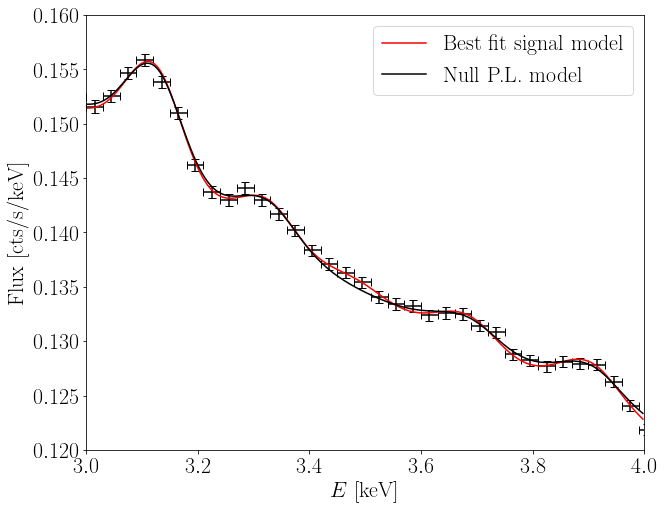

In [26]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"


plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
x0 = np.array([bf_QPB[0],bf_QPB[1], 0.064218, -0.4306988 , 0.02542355 , 0.01451921 , 0.09027154,  0.03331636])
plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")

plt.xlim(3,4)

plt.ylim(0.12,0.16)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [27]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.04332893986686534 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 3.822592337461016e-11


In this analysis we find a large feature at 3.48 keV with TS $\sim 10$. 

As in the previous section, let's for a moment assume this feature is physical. We find a best-fit $\sin^2(2\theta) = 3.64 \times 10^{-11}$ and a 95% limit $\sin^2(2\theta) = 3.82 \times 10^{-11}$.  This is immediately inconsistent with an interpretation as the 3.5 keV line. More strikingly, the same analysis on the cleaned data in the previous notebook found a 95% limit of $\sin^2(2\theta) = 1.70 \times 10^{-11}$, ruling out this detection, highlighting the importance of clean data.

Further we caution against a naive interpretation of TS $\sim 10$ as 3$\sigma$ anomaly. 3.48 is not the central value preferred by all UXL values, so the fact a line is preferred at this energy carries with it an additional degree of freedom in terms of the central line energy.

As we have seen, the lack of quality cuts on the data selection means that observations with extended emission have crept into the analysis. As compared to the reduced dataset with quality cuts, the flux is higher, and there are additional energy-dependent features in the data that complicate the analysis. In addition, observations with different backgrounds have been added together. As such, there is no reason to expect that these simple background models to reasonably describe the data at the level required to resolve weak signals. In this notebook, we have shown that not only can the addition of these high-background observations introduce artificial features into the data that can resemble an emission line, but they actually decrease the sensitivity to the signal. This is precisely why we implemented the quality cuts in our fiducial analysis.

# Previous analysis with a narrower energy range

Before finishing, let's repeat the above analysis in a narrower energy range.

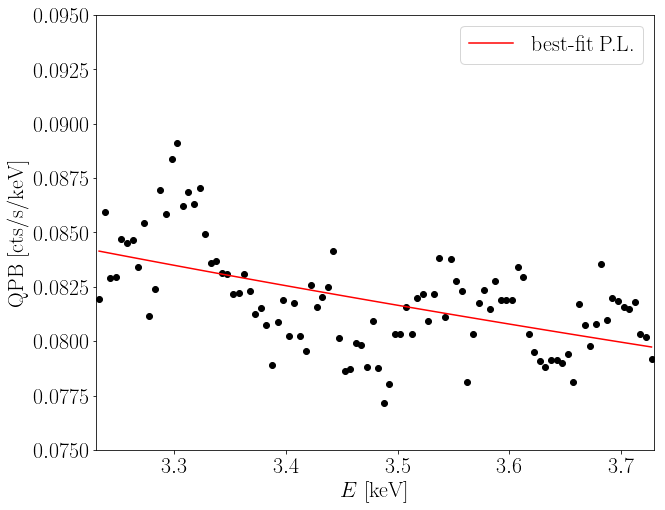

In [28]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

# We are going to fix a powerlaw to the QPB data and then renormalize the chi^2 function
def PL(A,n,ens):
    return A*ens**n
def chi2_QPB_UN(x):
    A,n = x
    mod = PL(A,n,Energies_reduced)
    return np.sum((mod-QPB[whs_reduced])**2)

mn_QPB = minimize(chi2_QPB_UN,[0.084,-0.20],method="Nelder-Mead")
bf_QPB=mn_QPB.x
chi2_not_reduced = chi2_QPB_UN(bf_QPB)

# The function below has the expected normalization
chi2_QPB = lambda x: chi2_QPB_UN(x)/chi2_not_reduced*((len(QPB[whs_reduced])-2.))

fig = plt.figure(figsize=(10,8))
plt.scatter(Energies_reduced,QPB[whs_reduced],marker="o",color="black")
plt.plot(Energies_reduced,PL(bf_QPB[0],bf_QPB[1],Energies_reduced),'r-',label="best-fit P.L.")
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"QPB [cts/s/keV]",fontsize=22)
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.075,0.095)
plt.legend(fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [29]:
def mod_2power_two_lines(ens,x):
    AQPB, nQPB,A, n,S1, S2 = x
    return PL(AQPB,nQPB,ens)+ folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_2power_two_lines,mod_UXL_reduced)
x0 = np.array([0.11129247, -0.25195735 , 0.40423702 ,-1.50156748  ,0.06552511,
  0.04919298 ])
bounds = np.array([[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.5],[0,0.5]])

# Below is the joint likelihood for the null model
def joint_chi2(x):
    return chi2_QPB(x[:2])+chi2_instance.chi2_null(x)
mn_null = dual_annealing(joint_chi2,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)

# Below is the joint likelihood for the signal model
def joint_chi2_sig(x):
    return chi2_QPB(x[1:3])+chi2_instance.chi2(x)
boundss = np.array([[-0.5,0.5],[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.5],[0,0.5]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(joint_chi2_sig,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=1000)
print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.13102155 -0.37746109  0.27567484 -1.18843237  0.05421866  0.02232009]
Best fit signal+background parameters: [ 0.01159417  0.1310049  -0.37736457  0.29067706 -1.23756125  0.0605592
  0.03399521]
The Delta chi^2 between signal and null model is: 1.0339052154868114
NB: the best-fit signal strength in this case is: 0.011594166953147068 cts/cm$^2$/s/sr


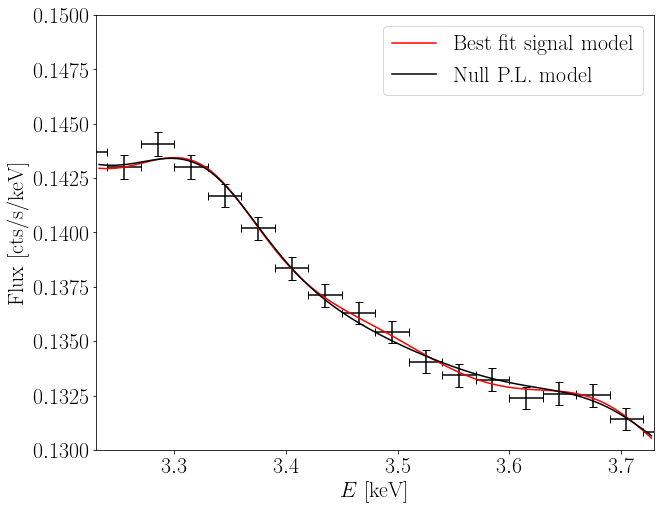

In [30]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"
plt.plot(Energies_reduced,mod_2power_two_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
x0 = np.array([bf_QPB[0],bf_QPB[1], 0.064218, -0.4306988 , 0.02542355 , 0.01451921 , 0.09027154,  0.03331636])
plt.plot(Energies_reduced,mod_2power_two_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")

plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.13,0.15)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [31]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun
amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.030215176915257585 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.665661890325141e-11


This time there is no significant detection of a feature, and instead we find a limit in tension with the best fit value above. This highlights that any feature at these origins likely originates from a systematic error in the background model.

# Summary

To summarize, we do not find robust evidence for the UXL, even when using data without quality cuts. We obtain the following limits on $\sin^2(2\theta)$ for $E_{\rm UXL} = 3.48$ keV:

* Quadratic background fit within $E_{\rm UXL} \pm 0.25$ keV: $3.08 \times 10^{-11}$

* Power law background fit within $E_{\rm UXL} \pm 0.25$ keV: $2.42 \times 10^{-11}$

* Power law background fit from 3 to 4 keV: $2.47 \times 10^{-11}$. This analysis is, as best as we can replicate, the BMRS analysis. We were unable to reproduce a 4.0$\sigma$ detection of the 3.5 keV line.

* Quadratic background fit from 3 to 4 keV: $3.29 \times 10^{-11}$. In this and the previous analysis we find mild evidence for a line with TS $\sim 3$, however, the best-fit signal is much too small to explain the BMRS detection. 

* Power law background fit on background-subtracted data from 3 to 4 keV: $4.87 \times 10^{-11}$

* Power law background fit with joint (X-ray + QPB) likelihood from 3 to 4 keV: $3.82 \times 10^{-11}$. In the previous two analyses we find some evidence for a feature at 3.48 keV, with TS $\sim 5$ and $10$, respectively. However, all evidence points towards an explanation as background mismodeling, given the lack of quality cuts. In fact, in both cases the same analysis on the cleaned data rules out the best fit found here.

* Power law background fit with joint (X-ray + QPB) likelihood over a narrow energy range: $2.67 \times 10^{-11}$

Although these limits are much weaker than our fiducial limit presented in DRS20, they still strongly constrain the 3.5 keV line.